In [1]:
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.formula.api as smf

np.random.seed(777)

#### Difference-in-Differences

In [2]:
df1 = pd.DataFrame({
    'd': 0, 'x': np.arange(50),
    'y': np.arange(50) + np.random.normal(0, 10, 50)
})

df2 = pd.DataFrame({
    'd': 1, 'x': np.arange(50),
    'y': np.arange(50) + 50 + np.random.normal(0, 10, 50)
})

df = pd.concat([df1, df2])

In [3]:
def calc_trend(df, x, y):
    z = np.polyfit(df[x], df[y], 1)
    p = np.poly1d(z)
    return p(df[x])

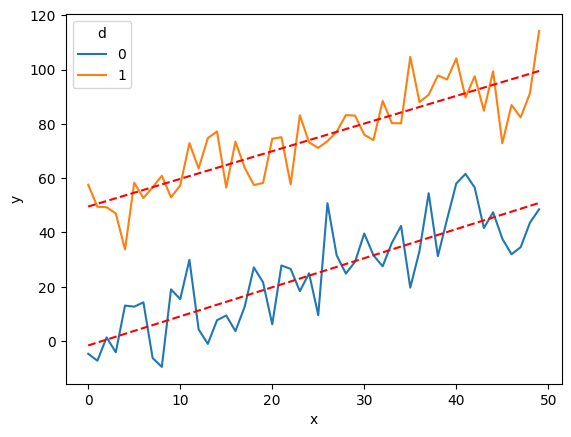

In [4]:
_ = sns.lineplot(x='x', y='y', hue='d', data=df)
_ = plt.plot(df[df['d']==0]['x'], calc_trend(df[df['d']==0], 'x', 'y'), 'r--')
_ = plt.plot(df[df['d']==1]['x'], calc_trend(df[df['d']==1], 'x', 'y'), 'r--')

In [5]:
new_data1 = pd.DataFrame({
    'd': 0, 'x': np.arange(50, 60),
    'y': np.arange(50, 60) + np.random.normal(0, 10, 10)
})
df1_add = pd.concat([df1, new_data1])

new_data2 = pd.DataFrame({
    'd': 1, 'x': np.arange(50, 60),
    'y': np.arange(65, 75)+ 50 + np.random.normal(0, 10, 10)
})
df2_add = pd.concat([df2, new_data2])
counterfactual = pd.DataFrame({
    'd': 1, 'x': np.arange(50, 60),
    'y': np.arange(50, 60)+ 50 + np.random.normal(0, 10, 10)
})

df = pd.concat([df1_add, df2_add])
counterfactual_df = pd.concat([df2, counterfactual])

C:\Users\49162\AppData\Local\Temp\ipykernel_14760\1113991498.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  _ = plt.plot(df[(df['d']==1)]['x'], calc_trend(df[(df['d']==1)], 'x', 'y'), 'r--', color='green')


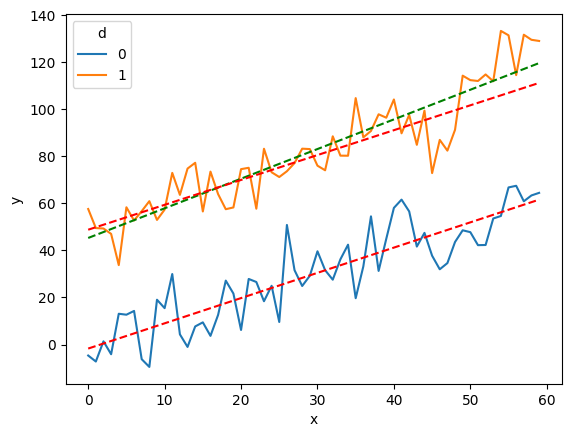

In [6]:
_ = sns.lineplot(x='x', y='y', hue='d', data=df)
_ = plt.plot(df[(df['d']==0)]['x'], calc_trend(df[(df['d']==0)], 'x', 'y'), 'r--')
_ = plt.plot(df[(df['d']==1)]['x'], calc_trend(df[(df['d']==1)], 'x', 'y'), 'r--', color='green')
_ = plt.plot(counterfactual_df['x'], calc_trend(counterfactual_df, 'x', 'y'), 'r--')

In [7]:
# pre- and post-intervention
df['post_int'] = np.where(df.x < 50, 0, 1)
df_ols = df.drop('x', axis=1)

smf.ols('y ~ post_int*d', data=df_ols).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,24.6330,2.405,10.241,0.000,19.869,29.397
post_int,31.6869,5.892,5.378,0.000,20.018,43.356
d,49.8750,3.402,14.662,0.000,43.138,56.612
post_int:d,15.8073,8.332,1.897,0.060,-0.696,32.310


#### Matching & Propensity Score

Assumptions to check for:
- Covariate balance between the treatment and new control (SMD less than 0.1 is generally considered to indicate good balance for covariate, 0.1-0.2 is acceptable)

$$SMD_j = \frac{\overline{X}_1 - \overline{X}_0}{\sqrt{\frac{S_1^2 + S_0^2}{2}}} \$$
- Distributions of propensity scores should be similar
- Overlap between the treated and untreated population

Additional formulas
- propensity score: estimate the probability of getting the treatment for all units: $$P(D = 1 | X)$$

In [8]:
col_names = {'S3': 'success_expect', 'C1': 'ethnicity', 'C2': 'gender',
            'C3': 'first_in_generation', 'XC': 'urbanicity', 'X1': 'school_mindset',
            'X2': 'school_achievement', 'X3': 'ethnic_minority_composition',
            'X4': 'poverty_concentration', 'X5': 'school_size',
            'Z': 'intervention', 'Y': 'achievement_score'}
dataset_url = 'https://raw.githubusercontent.com/grf-labs/grf/master/experiments/acic18/synthetic_data.csv'
df = pd.read_csv(dataset_url, header=0)
df.columns = df.columns.map(col_names).str.lower()
df = df.iloc[:, 1:].copy()
df.sample(5)

,intervention,achievement_score,success_expect,ethnicity,gender,first_in_generation,urbanicity,school_mindset,school_achievement,ethnic_minority_composition,poverty_concentration,school_size
9644,0,-1.037095,4,13,2,1,1,0.088526,1.307292,-1.277419,-1.361184,-0.869961
3420,0,-0.695092,5,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1819,1,-0.500948,5,4,2,1,1,1.731915,-0.587886,-0.986201,0.540381,-1.606304
7035,0,-0.479697,5,4,1,1,3,0.309833,0.303984,0.515392,1.274088,-1.539801
2777,1,-0.241150,5,10,1,0,3,0.230570,-0.753309,-0.963095,-0.054781,-0.583241


In [9]:
cat = ["ethnicity", "gender", "urbanicity"]

df_cat = pd.concat(
    [df.drop(columns=cat),
    pd.get_dummies(df[cat], columns=cat, drop_first=False)],
    axis=1
)

In [10]:
X = df_cat.columns.drop(['intervention', 'achievement_score'])

ps_model = LogisticRegression(C=1e9).fit(df_cat[X], df_cat['intervention'])
data_ps = df.assign(
    propensity_score=ps_model.predict_proba(df_cat[X])[:, 1]
)

data_ps[["intervention", "achievement_score", "propensity_score"]].sample(5)

,intervention,achievement_score,propensity_score
3774,0,-0.207023,0.373073
3783,0,0.835530,0.390924
3579,0,-0.292301,0.270526
9282,0,-0.163759,0.305993
9954,0,0.114190,0.362987


In [11]:
treated = data_ps[data_ps['intervention'] == 1]
control = data_ps[data_ps['intervention'] == 0]

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control[['propensity_score']])
distances, indices = nbrs.kneighbors(treated[['propensity_score']])

matched_control = control.iloc[indices.flatten()]

In [12]:
covariates = data_ps.drop(columns=['intervention', 'achievement_score', 'propensity_score']).columns
smd = []
for covariate in covariates:
    mean_treated = treated[covariate].mean()
    mean_control = matched_control[covariate].mean()
    std_pooled = np.sqrt((treated[covariate].var() + matched_control[covariate].var()) / 2)
    smd.append((mean_treated - mean_control) / std_pooled)
smd = np.array(smd)

assert len([i for i in smd if i > 0.1]) == 0

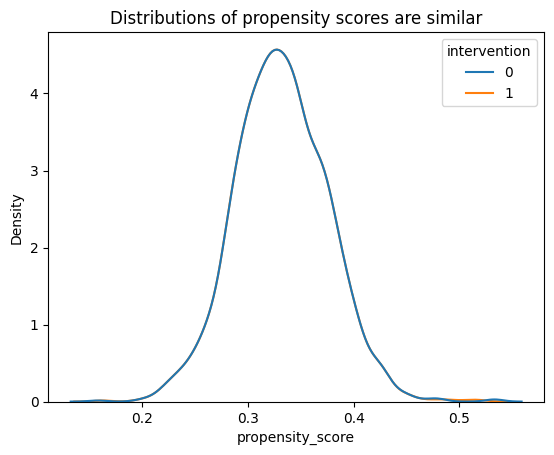

In [13]:
_ = sns.kdeplot(
    x='propensity_score', hue='intervention',
    data=pd.concat([treated, matched_control])
)
plt.title('Distributions of propensity scores are similar')
plt.show()

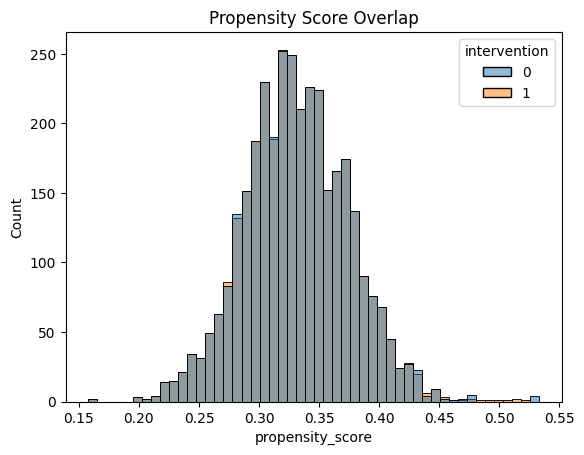

In [14]:
_ = sns.histplot(
    x='propensity_score', hue='intervention', data=pd.concat([treated, matched_control]),
    bins=50, color='blue', alpha=0.5)
plt.title('Propensity Score Overlap')
plt.show()

In [15]:
smf.ols(
    "achievement_score ~ intervention + propensity_score",
    data=pd.concat([treated, matched_control])
).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.1698,0.054,-39.966,0.000,-2.276,-2.063
intervention,0.2279,0.014,16.300,0.000,0.201,0.255
propensity_score,6.1825,0.161,38.401,0.000,5.867,6.498


#### Instrumental Variables